# 用PaddlePaddle复现Fourier Neural Operator

## 简介

Fourier Neural Operator 模型是Fourier Neural Operator for Parametric Partial Differential Equations一文中提出的模型。该模型尝试去学习基于傅里叶变换的有限维算子的参数化，去数值逼近一些偏微分方程。该模型比起其他尝试用深度学习求解复杂的偏微分方程数值解的模型相比，具备以下几个很重要的特点：

- 训练比较容易，可以用低分辨率的数据去训练，而直接在高分辨率的数据上推理。
- 与PINN不一样，在方程的参数、初始条件变动的时候，不需要额外的训练。

Fourier Neural Operator是算子学习类的模型，也被证明了有更好的泛化能力，在分辨率、方程参数、初始条件变动的时候，并不需要重新训练。因此该模型具备较好的落地能力。

## 模型的基本原理

神经网络算子(Neural Operators)是一类机器学习范式，要理解傅里叶神经网络算子，我们要先理解什么是神经网络算子。

#### 什么是神经网络算子

假设我们现在有一个偏微分方程写成了算子模式：

$$
(\mathcal{L}_a u) (x) = f(x), x\in D\\
u(x) =0, x\in \partial D
$$

其中$\mathcal{L}$ 是一个算子，而a是算子的参数，我们现在想求出u(x)。使用格林函数法，我们可以构造出一个格林函数$G_a(x,y)$，使得：

$$
u(x) = \int_D G_a(x,y) f(y) dy
$$

这个格林函数可以被视作一个核函数(Kernel function)，举一个具体的例子，假设$G_a$已经被我们学习出来了，那么我们要计算$u(0)$的时候，我们就可以计算：

$$
u(0) = \int_D G_a(0,y) f(y) dy
$$

这个计算过程可以被视作一个卷积运算，因此我们可以用神经网络来模拟这个核函数$G_a$，也就可以用神经网络来求解算子方程$(\mathcal{L}_a u )(x)=f(x)$了。

#### 什么是傅里叶神经网络算子

FNO和上述的NO相比，多了一个步骤就是将核函数$G_a$通过傅里叶变换变成了频域，然后再通过一个神经网络去学习这个频域的核函数。这个频域的核函数可以被视作一个频域的卷积核。傅里叶空间里每一个点都是有良好定义的，只与不同的频谱有关，与实际离散空间的离散无关。因此模型能在低分辨率的离散空间上训练，而且在高分辨率的离散空间上推理。

仍然参考上述的符号，我们可以将傅里叶神经网络算子的计算过程写成：

$$
(\mathcal{L}_a u) (x) = \mathcal{F}^{-1}(\mathcal{F}(\mathcal{L}_a) \cdot \mathcal{F}(u))(x), x\in D
$$

其中，$\mathcal{F}$是傅里叶变换，$\mathcal{F}^{-1}$是傅里叶逆变换，$\cdot$是卷积运算。

## 模型的结构

FNO模型的结构如下图所示：

- 给定输入a(x)的数据，先通过卷积层将其提取成高维的特征空间。
- 通过多层的傅里叶算子积分层
- 将输出投影会原始的空间，输出u(x)。

其中，傅里叶算子积分层的计算过程如下：

- 给定输入v(x)，通过傅里叶变换得到频域的v(k)。
- 将v(k)和b(k)进行卷积运算，得到频域的输出w(k)。
- 将w(k)通过傅里叶逆变换得到空间域的输出w(x)。
- 添加残差连接，w(x) = w(x) + v(x)，得到最终的输出。

模型定义在`neuralop/models/tfno.py`中可以找到。

## 训练流程

下面的代码定义了一个简单的训练流程。使用官方代码给出的Darcy flow 数据集，我们尝试训练一个FNO模型来预测二维的达西流问题。这个问题的偏微分方程为：

$$
-\nabla \cdot (k(x) \nabla u(x)) = f(x),  x\in D
$$

其中，x是位置，u(x) 是流体的压力，k(x)是渗透率场，f(x) 是压力的函数。达西流问题可以被用来描述多孔介质的流动、弹性材料和热传导。在这里，我们定义了一个二维的平面区域$D = [0,1] \times [0,1]$，我们希望得到一个模型，可以在给定k渗透率场的情况下，估算出u流体压力。

In [1]:
import sys
sys.path.append('/home/aistudio/neuralop')

import warnings
warnings.filterwarnings("ignore")

#### 数据示例

在下面的单元格中，我们展示了一些训练数据的可视化，方便理解：


##### 定义dataloader

In [2]:
from neuralop.datasets.darcy import load_darcy_flow_small
import paddle
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=1000, batch_size=32,
    test_resolutions=[16, 32], n_tests=[100, 50], test_batch_sizes=[32, 32],
)

train_dataset = train_loader.dataset


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape [1, 1, 1], eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


W0322 10:30:31.491677   289 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0322 10:30:31.496592   289 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


##### 可视化

左侧的图中，k(x)的黑色区域就是可以渗透的地方，白色为不可渗透的区域。右侧是目标结果，颜色越亮，压力越大。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

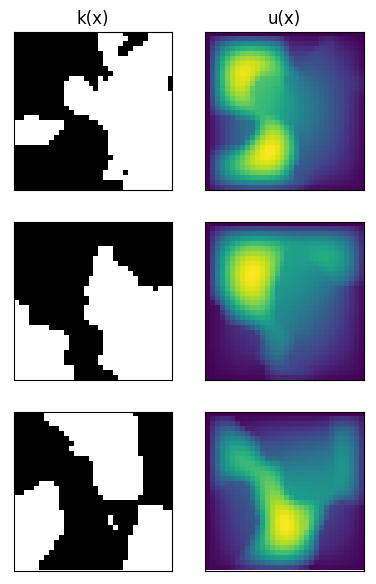

In [3]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data["x"]
    # Ground-truth
    y = data["y"]

    ax = fig.add_subplot(3, 3, index * 3 + 1)
    ax.imshow(x[0], cmap="gray")
    if index == 0:
        ax.set_title("k(x)")
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("u(x)")
    plt.xticks([], [])
    plt.yticks([], [])

##### 训练模型

如果你使用的是CPU实例，下面的过程可能需要大概5分钟。

In [4]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64)

optimizer = paddle.optimizer.Adam(learning_rate=1e-3 , parameters=model.parameters())

# cosine annealing scheduler
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=1e-3, T_max=1000)

loss = LpLoss(d=2, p=2)
h1_loss = H1Loss(d=2)



train_loss = h1_loss
eval_losses = {"h1": h1_loss, "l2": loss}

trainer = Trainer(model, n_epochs=20,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  verbose=True)


trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on regular inputs (no multi-grid patching).
Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
[0] time=2.91, avg_loss=20.9791, train_err=0.4196, 16_h1=0.2937, 16_l2=0.2345, 32_h1=0.4540, 32_l2=0.2514
[3] time=0.86, avg_loss=9.7800, train_err=0.1956, 16_h1=0.1898, 16_l2=0.1464, 32_h1=0.3499, 32_l2=0.1774
[6] time=0.80, avg_loss=8.2632, train_err=0.1653, 16_h1=0.1688, 16_l2=0.1232, 32_h1=0.3204, 32_l2=0.1506
[9] time=0.85, avg_loss=7.6710, train_err=0.1534, 16_h1=0.1622, 16_l2=0.1177, 32_h1=0.3076, 32_l2=0.1475
[12] time=0.73, avg_loss=7.0439, train_err=0.1409, 16_h1=0.1574, 16_l2=0.1138, 32_h1=0.2992, 32_l2=0.1444
[15] time=0.70, avg_loss=6.6445, train_err=0.1329, 16_h1=0.1558, 16_l2=0.1097, 32_h1=0.2907, 32_l2=0.1274
[18] time=0.74, avg_loss=6.2937, train_err=0.1259, 16_h1=0.1522, 16_l2=0.1076, 32_h1=0.2945, 32_l2=0.1376


##### 使用训练好的模型进行预测

注意，我们这里用来测试的数据，空间分辨率是$32*32$，比训练用的$16*16$要高，这个设定是为了展示FNO模型对分辨率的不敏感。从结果中可以看出，模型能给出很好的结果，而且计算速度非常快。

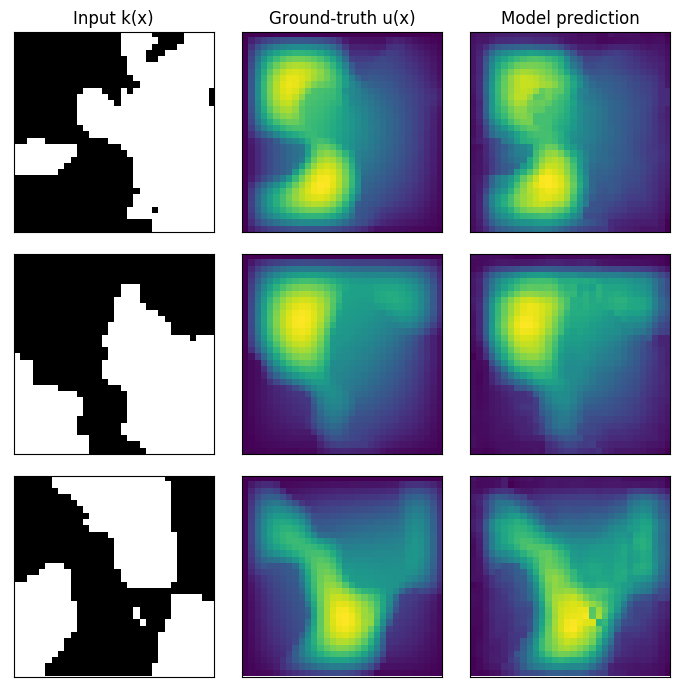

In [5]:


test_samples = test_loaders[32].dataset
fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).cuda()).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input k(x)')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth u(x)')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

plt.tight_layout()
fig.show()

## 复现心得

本次复现相对容易，理解了模型原理后，参考官方给出的代码改成paddle的过程并不复杂。主要遇到的障碍是paddle对复数算子的支持。

#### 1. `create_parameter`不支持复数参数

paddle中，模型层的参数需要单独的`create_parameter`声明，目前该函数不支持复数。所以我们采取了一个折中的办法，就是创建两份参数，一份是实部，一份是虚部。

```python
class FactorizedTensor(nn.Layer):
    def __init__(self, shape, init_scale):
        super().__init__()
        self.shape = shape
        self.init_scale = init_scale
        self.real = self.create_parameter(
            shape=shape, default_initializer=nn.initializer.XavierNormal()
        )
        self.imag = self.create_parameter(
            shape=shape, default_initializer=nn.initializer.XavierNormal()
        )

    def __repr__(self):
        return f"FactorizedTensor(shape={self.shape})"

    @property
    def data(self):
        return paddle.complex(self.real, self.imag)
```

具体计算使用的时候，使用FactorizedTensor.data进行取出。

#### 2. `einsum` 对复数求梯度有误

当前的版本下（2.4.0），einsum算子在输入输出有复数的情况下，求梯度是有误的。目前我们采取的方法是手动拆分了复数计算的过程为两个实数计算，最后手动累加。

基于公式：
$$
(a+bi)(c+di) = (ac - bd) + (ad + bc) i
$$

我们使用了如下的折中方案：

原来的写法：

```python
x = paddle.einsum(eq, x, weight)
```

新的写法：

```python
o1_real = paddle.einsum(eq, x.real(), weight_real) - paddle.einsum(
        eq, x.imag(), weight_imag
    )
o1_imag = paddle.einsum(eq, x.imag(), weight_real) + paddle.einsum(
    eq, x.real(), weight_imag
)
x = paddle.complex(o1_real, o1_imag)
```